In [2]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt
import pandas as pd
blue, *_ = sns.color_palette()


SEED = 5132290 # from random.org

np.random.seed(SEED)

N = 20
K = 30

alpha = 2.
P0 = sp.stats.norm

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
from scipy import stats

In [4]:
df = pd.DataFrame(load_iris()['data'])
y = df.values
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

# A 2D pairplot between variables
df['target'] = load_iris()['target']

In [10]:
N = old_faithful_df.shape[0]

K = 35

In [21]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [22]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    pi = pm.Deterministic('pi', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 1, shape=K)
#     mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    mu0 = pm.Uniform('mu0', -3, 3, shape=K)
    
    mu = pm.Normal('mu', mu=mu0, tau=1, shape=K)
    obs = pm.NormalMixture('obs', pi, mu, tau=lambda_ * tau,
                           observed=y[:, 2])

In [23]:
with model:
    trace = pm.sample(1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, mu0, lambda, tau, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 3000/3000 [01:50<00:00, 27.25draws/s]
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


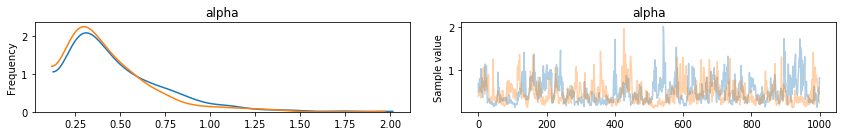

In [24]:
pm.traceplot(trace, varnames=['alpha']);

In [43]:
trace['pi'].shape

(2000, 30)

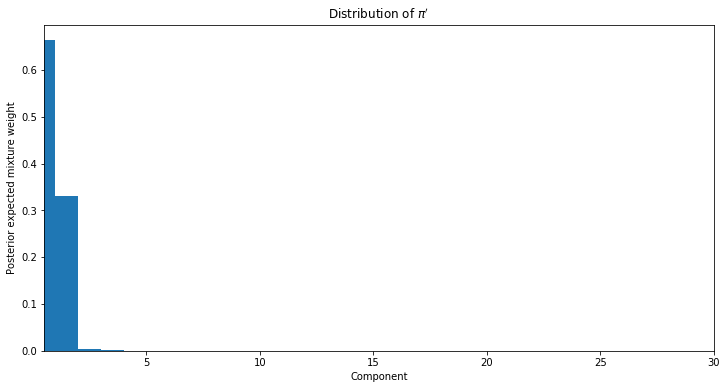

In [25]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of $\pi'$")
plt.bar(np.arange(K) + 1 - 0.5, trace['pi'].mean(axis=0), width=1., lw=0);
plt.xlim(0.5, K);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

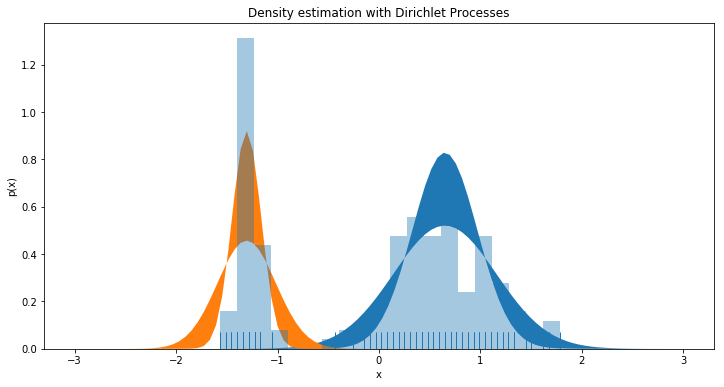

In [44]:
plt.figure(figsize=(12, 6))
plt.title('Density estimation with Dirichlet Processes')
plt.xlabel('x')
plt.ylabel('p(x)')
x = np.linspace(-3,  3, 100)
pi_mean = trace['pi'].mean(0)
mu_mean = trace['mu'].mean(0) 
mu0_mean = trace['mu0'].mean(0)
lambda_mean = trace['lambda'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_mean))
tau_sd = trace['mu'].std(0)
lambda_sd = trace['lambda'].std(0)
sd_std = np.sqrt((1 / tau_sd * lambda_sd))

p = stats.norm.interval(0.05, trace['mu'].mean(0), trace['mu'].std(0))
psd = stats.norm.interval(0.05, sd_mean, sd_std)

for idx in range(0,2):
    plt.fill_between(x, stats.norm.pdf(x, mu_mean[idx], psd[0][idx]) * pi_mean[idx], stats.norm.pdf(x, mu_mean[idx], psd[1][idx]) * pi_mean[idx])

sns.distplot(y[:, 2], bins=20, kde=None, norm_hist=True, rug=True, )

In [46]:
sd_mean.shape, sd_std.shape

((30,), (30,))

In [48]:
psd

(array([0.31968513, 0.14317978, 0.66861225, 0.68452319, 0.67690984,
        0.68138348, 0.68536962, 0.66786368, 0.69410538, 0.6821956 ,
        0.68774147, 0.67560736, 0.67767471, 0.68493602, 0.6964761 ,
        0.68075493, 0.66475414, 0.68875465, 0.6791596 , 0.67821249,
        0.67836025, 0.67607307, 0.68916835, 0.67702066, 0.67845553,
        0.6905942 , 0.69998808, 0.68860222, 0.67888665, 0.68180718]),
 array([0.50911287, 0.2879968 , 0.71618903, 0.73289712, 0.72489333,
        0.72946561, 0.73300662, 0.71649868, 0.74215922, 0.72869402,
        0.73528537, 0.72314822, 0.72598008, 0.73238316, 0.74353228,
        0.72782809, 0.71224295, 0.73696136, 0.7270286 , 0.72634908,
        0.72443186, 0.72318367, 0.7367732 , 0.72569732, 0.72644062,
        0.73762112, 0.74787705, 0.73590427, 0.72626313, 0.72935715]))

In [40]:
clusters = np.vstack([stats.norm.pdf(y[:, 2], mu_mean[idx], psd[1][idx]) * pi_mean[idx] \
          for idx in range(3)])[::-1].argmax(axis=0)

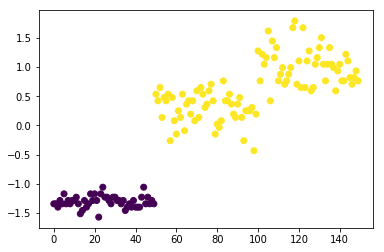

In [41]:
plt.scatter(np.arange(len(y)), y[:, 2], c = clusters)

In [19]:
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdf_contribs.shape

(2000, 200, 30)

In [20]:
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)
post_pdfs.shape

(2000, 200)

In [22]:
post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)
post_pdf_low.shape

(200,)

C:\Users\ciort\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


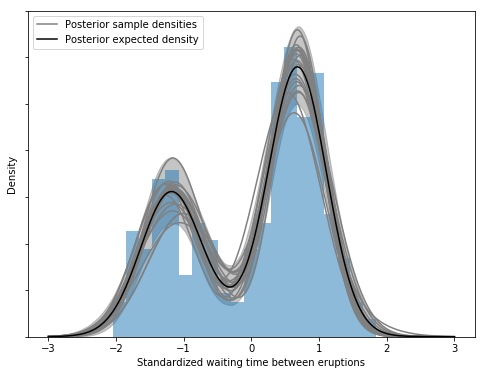

In [18]:

fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

In [ ]:
trace.varnames

In [ ]:
y =old_faithful_df.std_waiting.values

In [ ]:
mu_mean

https://www.ritchievink.com/blog/2018/06/05/clustering-data-with-dirichlet-mixtures-in-edward-and-pymc3/

https://docs.pymc.io/notebooks/dp_mix.html

https://www.datasciencecentral.com/profiles/blogs/6448529:BlogPost:635167

https://stackoverflow.com/questions/41553988/how-to-extract-unsupervised-clusters-from-a-dirichlet-process-in-pymc3

In [ ]:
from scipy import stats
plt.figure(figsize=(12, 6))
plt.title('Density estimation with Dirichlet Processes')
plt.xlabel('x')
plt.ylabel('p(x)')
x = np.linspace(-3,  3, 100)
pi_mean = trace['w'].mean(0)
mu_mean = trace['mu'].mean(0) 
# mu0_mean = trace['mu0'].mean(0)
lambda_mean = trace['lambda'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_mean))
tau_sd = trace['mu'].std(0)
lambda_sd = trace['lambda'].std(0)
sd_std = np.sqrt((1 / tau_sd * lambda_sd))

p = stats.norm.interval(0.05, trace['mu'].mean(0), trace['mu'].std(0))
psd = stats.norm.interval(0.05, sd_mean, sd_std)

for idx in range(1,4):
    plt.fill_between(x, stats.norm.pdf(x, mu_mean[idx], psd[0][idx]) * pi_mean[idx], stats.norm.pdf(x, mu_mean[idx], psd[1][idx]) * pi_mean[idx])
# plt.fill_between(x, stats.norm.pdf(x, mu_mean[idx], psd[0][idx]) * pi_mean[idx], stats.norm.pdf(x, mu_mean[idx], psd[1][idx]) * pi_mean[idx])
sns.distplot(y, bins=20, kde=None, norm_hist=True, rug=True, )

In [ ]:
sns.distplot(old_faithful_df.std_waiting.values, bins=20, kde=None, norm_hist=True, rug=True, )

In [ ]:
for i in range(3):
    pi_s.mean(0)[i] * 
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y)
    

In [ ]:
np.vstack([pi_s.mean(0)[i] * \
           stats.multivariate_normal(mu_s.mean(0)[i], np.sqrt(sigmasq_s.mean(0))[i]).pdf(y) \
          for i in range(3)])[::-1].argmax(axis=0).sum() / df.shape[0]

In [ ]:
def stick_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[..., :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[..., :-1]],
                              axis=1)

K = 10
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=(1, K))
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/w.sum()

    tau = pm.Gamma('tau', 1., 1., shape=(2, K))
    lambda_ = pm.Uniform('lambda', .0001, 5, shape=(2, K))
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=(2, K))
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, comp_shape=(2, K),
                           observed=np.random.randn(100, 2, 1))
    trace = pm.sample()